In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import cv2
from tdmclient import ClientAsync, aw
from utils.camera import *
from utils.thymio import *
from utils.path import *
from utils.motion_control import *
from utils.buttons import*
from utils.drawings import *
from utils.color_thresholds import load_thresholds
###########################################################
# Parameters
###########################################################
COLOR_OBSTACLE = np.array([[80, 40, 0, 255, 70, 20]]) #BGR
COLOR_GOAL = np.array([0, 77, 0, 68, 255, 118])         #BGR
#COLOR_OBSTACLE = load_thresholds("color_obstacles.txt").reshape(1,-1) # run the notebook inside utils and save thresholds
#COLOR_GOAL = load_thresholds("color_goal.txt")


###########################################################
# Main Code
###########################################################
from tdmclient import ClientAsync, aw
client = ClientAsync()

xytheta = np.zeros((1, 3))

async def main():
    global xytheta
    node = await client.wait_for_node()
    aw(node.lock())
    
    print("Press forward button to start the program")
    beginning = False
    while(beginning == False) :
        beginning = await wait_for_start_button(node, client)
        time.sleep(0.3)
    cv2.destroyAllWindows()
    print("Starting the program")

    program = '''
        # Turn off LEDs during initialization
        call leds.temperature(0, 0)
        call leds.prox.v(0, 0)
        '''
    await node.compile(program)
    await node.run()
    
    # Camera initialization
    cam = camera_class(COLOR_OBSTACLE,COLOR_GOAL)
    while not cam.corners_found:
        cam = camera_class(COLOR_OBSTACLE, COLOR_GOAL)


    # Thymio initialization
    Thymio = Thymio_class(cam)
    step = 0
    
    while step<100 :  
        
        step = step + 1
        print(step)
        # Update Image
        cam.get_image()
        cam.correct_perspective_aruco(get_matrix = False)
        
        # Thymio Position and motor
        Thymio.Thymio_position_aruco(cam.persp_image)
        Thymio.delta_time_update()

        if not Thymio.Thymio_detected:
            continue
        xytheta = np.vstack((xytheta, Thymio.xytheta_meas))


        #Check stop
        if(await check_stop_button(node, client)):
            aw(node.stop())
            aw(node.unlock())
            break
    cam.cam.release()
    aw(node.stop())
    aw(node.unlock())
    # cv2.destroyAllWindows()


client.run_async_program(main)

Press forward button to start the program
Starting the program
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100


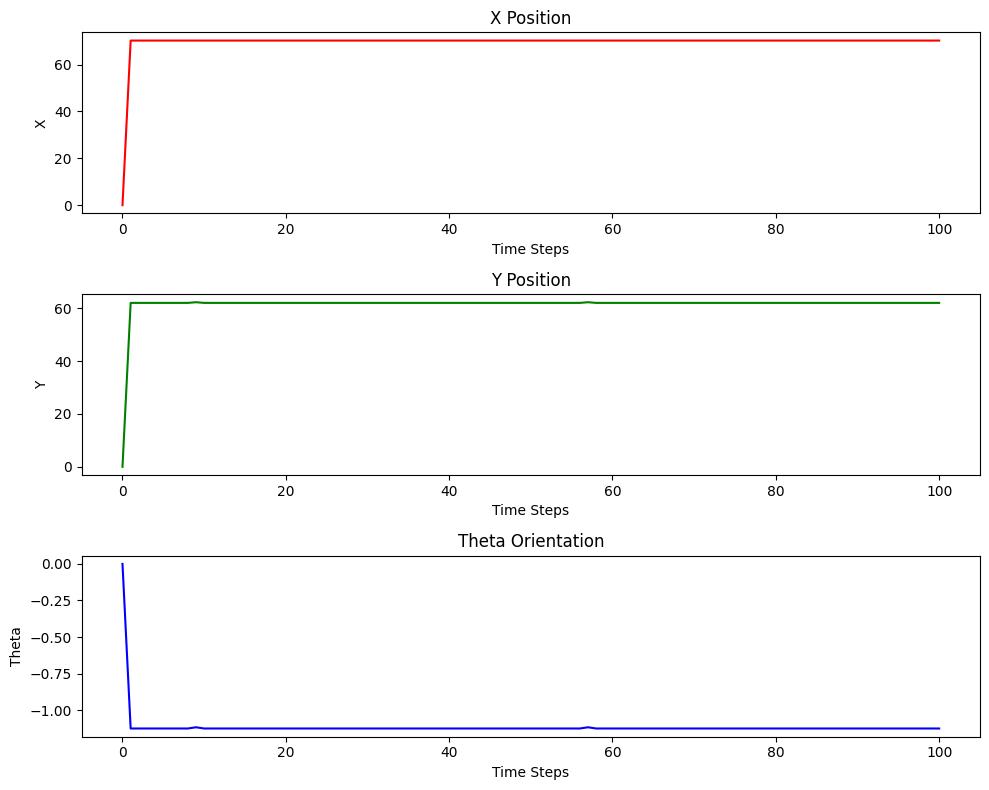

In [3]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 1, figsize=(10, 8))  # 3 rows, 1 column for subplots

axs[0].plot(xytheta[:, 0], color='r')
axs[0].set_title('X Position')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('X')

axs[1].plot(xytheta[:, 1], color='g') 
axs[1].set_title('Y Position')
axs[1].set_xlabel('Time Steps')
axs[1].set_ylabel('Y')

axs[2].plot(xytheta[:, 2], color='b')
axs[2].set_title('Theta Orientation')
axs[2].set_xlabel('Time Steps')
axs[2].set_ylabel('Theta')
plt.tight_layout()
plt.show()

In [5]:
np.var(xytheta[15:, 0]), np.var(xytheta[15:, 1]), np.var(xytheta[15:, 2])

(np.float64(0.0),
 np.float64(0.0007182936722552728),
 np.float64(7.822214473964099e-07))